# Model evaluation and recording

In this notebook you can find routines for model evaluation and episode recording.

To evaluate model you need to provide path to it, available within experiments' output directory: `experiment-date--time/epoch-xx/model`. Follow examples below.

In [1]:
import numpy as np
import tensorflow as tf
import gym
from celluloid import Camera
import matplotlib.pyplot as plt
from typing import List, Callable
plt.rcParams['figure.facecolor'] = 'xkcd:light grey'
plt.rcParams['figure.dpi'] = 200

In [2]:
grayscale_code = ! cat '../implementation/environment/__init__.py'
exec('\n'.join(grayscale_code))

## Available methods

- `evaluate_model_with_seeds` to run model with different initial environment conditions
- `evaluate_model` evaluates model with seed and offers recording to file

In [3]:
def preprocess(obs):
    obs = tf.gather(tf.constant(grayscale_palette), tf.cast(obs, tf.int32))
    obs = tf.reduce_max(obs, axis=2)
    resized = tf.image.resize(obs, (84, 84))
    return resized.numpy()

In [4]:
def evaluate_model(env_name: str, seed: int, model_path: str, output_type: str,
                   preprocess_func: Callable, recorded: bool = False, max_steps: int = 10000):
    env = gym.make(env_name)
    model = tf.keras.models.load_model(model_path)
    
    env.seed(seed)
    tf.random.set_seed(seed)
    obs = env.reset()
    done = False
    step_count = 0
    reward_sum = 0.
    
    if recorded:
        fig = plt.figure()
        camera = Camera(fig)
    
    while not done and step_count < max_steps:
        
        if recorded:
            image = env.render(mode='rgb_array')
            plt.imshow(image)
            plt.axis('off')
            camera.snap()
        
        action_logits = model(tf.expand_dims(preprocess_func(obs), 0))
        
        if output_type == 'categorical':
            action = tf.squeeze(tf.random.categorical(action_logits, 1))
        elif output_type == 'argmax':
            action = tf.math.argmax(action_logits, axis=1)
        else:
            raise Exception('invalid output type')
        
        obs, reward, done, _ = env.step(action.numpy())
        
        reward_sum += reward
        step_count += 1
    
    if recorded:
        animation = camera.animate(interval=35)
        animation.save(f'{env_name}-{seed}.gif')
        
    return reward_sum

In [5]:
def evaluate_model_with_seeds(env_name: str, seeds: List[int], model_path: str, output_type: str,
                              preprocess_func: Callable, max_steps: int = 10000):
    envs = []
    obses = []
    dones = np.full(len(seeds), False)
    count = 0
    rewards = np.zeros(len(seeds))
    model = tf.keras.models.load_model(model_path)
    tf.random.set_seed(seeds[0])
    
    for seed in seeds:
        env = gym.make(env_name)
        env.seed(seed)
        obs = env.reset()
        envs.append(env)
        obses.append(obs)

    while not np.all(dones) and count < max_steps:
        indices = np.where(~dones)[0]
        prepr = np.array([preprocess_func(obses[i]) for i in indices])
        action_logits = model(prepr)
        if output_type == 'categorical':
            actions = tf.squeeze(tf.random.categorical(action_logits, 1), axis=1)
        elif output_type == 'argmax':
            actions = tf.math.argmax(action_logits, axis=1)
        else:
            raise Exception('invalid output type')
        for idx, action in zip(indices, actions):
            obs, reward, done, _ = envs[idx].step(action.numpy())
            obses[idx] = obs
            dones[idx] = done
            rewards[idx] += reward
        count += 1

    return list(zip(seeds, rewards))

## Exemplary evaluations

### CartPole

In [ ]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-27--12-01/checkpoints/epoch-8/model'
evaluate_model('CartPole-v0', 1, path_to_model, output_type='categorical', 
               preprocess_func=lambda x: x, recorded=True)

### LunarLander

In [7]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-21--18-34/checkpoints/epoch-3/model'
evaluate_model_with_seeds('LunarLander-v2', [1, 2, 3, 4, 5], path_to_model,
                          output_type='categorical', preprocess_func=lambda x: x)

[(1, -92.28051167735717),
 (2, -90.26291348313367),
 (3, -134.5903325338844),
 (4, -94.92672640957295),
 (5, -63.34894748122113)]

In [8]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-21--18-34/checkpoints/epoch-31/model'
evaluate_model_with_seeds('LunarLander-v2', [1, 2, 3, 4, 5], path_to_model,
                          output_type='categorical', preprocess_func=lambda x: x)

[(1, 257.62723603962627),
 (2, 232.64767914621999),
 (3, 265.8042815078428),
 (4, 259.63988958940837),
 (5, 269.86749833062277)]

In [ ]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-21--18-34/checkpoints/epoch-31/model'
evaluate_model('LunarLander-v2', 5, path_to_model, output_type='categorical', 
               preprocess_func=lambda x: x, recorded=True)

### Atari Frostbite

In [10]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-56/model'
evaluate_model_with_seeds('Frostbite-v0', [6, 7, 8, 9, 10], path_to_model,
                          output_type='argmax', preprocess_func=preprocess)

[(6, 1450.0), (7, 3400.0), (8, 2640.0), (9, 2460.0), (10, 2640.0)]

MovieWriter ffmpeg unavailable; using Pillow instead.


3400.0

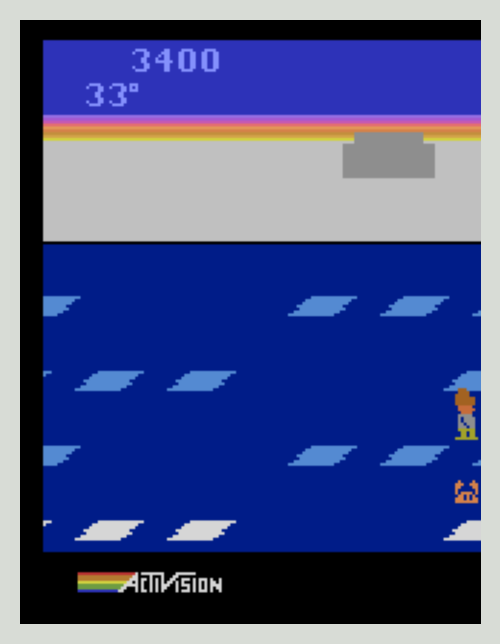

In [11]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-56/model'
evaluate_model('Frostbite-v0', 7, path_to_model, output_type='argmax', 
               preprocess_func=preprocess, recorded=True)

In [12]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-57/model'
evaluate_model_with_seeds('Frostbite-v0', [1, 2, 3, 4, 5], path_to_model,
                          output_type='argmax', preprocess_func=preprocess)

[(1, 2460.0), (2, 2500.0), (3, 2430.0), (4, 3450.0), (5, 2440.0)]

In [ ]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-57/model'
evaluate_model('Frostbite-v0', 4, path_to_model, output_type='argmax', 
               preprocess_func=preprocess, recorded=True)

In [14]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-57/model'
evaluate_model_with_seeds('Frostbite-v0', [6,7,8,9,10], path_to_model,
                          output_type='argmax', preprocess_func=preprocess)

[(6, 3140.0), (7, 2510.0), (8, 2810.0), (9, 3100.0), (10, 2430.0)]

In [ ]:
path_to_model = '/Users/mateusz/Desktop/final/experiment-2021-03-28--17-55/checkpoints/epoch-57/model'
evaluate_model('Frostbite-v0', 6, path_to_model, output_type='argmax', 
               preprocess_func=preprocess, recorded=True)

### Atari Kangaroo

In [6]:
path_to_model = '/Users/mateusz/Downloads/experiment-2021-03-30--02-09/checkpoints/epoch-37/model'
evaluate_model_with_seeds('Kangaroo-v0', [1,2,3,4,5], path_to_model,
                          output_type='argmax', preprocess_func=preprocess)

[(1, 800.0), (2, 1000.0), (3, 800.0), (4, 1400.0), (5, 600.0)]

In [ ]:
path_to_model = '/Users/mateusz/Downloads/experiment-2021-03-30--02-09/checkpoints/epoch-37/model'
evaluate_model('Kangaroo-v0', 4, path_to_model, output_type='argmax', 
               preprocess_func=preprocess, recorded=True)

### Atari Zaxxon

In [6]:
path_to_model = '/Users/mateusz/Downloads/experiment-2021-03-31--00-23/checkpoints/epoch-26/model'
evaluate_model_with_seeds('Zaxxon-v0', [1,2,3,4,5], path_to_model,
                          output_type='argmax', preprocess_func=preprocess)

[(1, 3900.0), (2, 2400.0), (3, 4400.0), (4, 3900.0), (5, 2700.0)]

In [ ]:
path_to_model = '/Users/mateusz/Downloads/experiment-2021-03-31--00-23/checkpoints/epoch-26/model'
evaluate_model('Zaxxon-v0', 3, path_to_model, output_type='argmax', 
               preprocess_func=preprocess, recorded=True)